In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
TRAIN_DIR = './data/train/train/'
TEST_DIR = './data/test/test/'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
    
    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,./data/train/train/sad\Training_67418316.jpg,sad
1,./data/train/train/happy\Training_51909940.jpg,happy
2,./data/train/train/neutral\Training_53401351.jpg,neutral
3,./data/train/train/sad\Training_42076481.jpg,sad
4,./data/train/train/fear\Training_96407409.jpg,fear


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,./data/test/test/angry\PrivateTest_10131363.jpg,angry
1,./data/test/test/angry\PrivateTest_10304478.jpg,angry
2,./data/test/test/angry\PrivateTest_1054527.jpg,angry
3,./data/test/test/angry\PrivateTest_10590091.jpg,angry
4,./data/test/test/angry\PrivateTest_1109992.jpg,angry


<Axes: xlabel='count', ylabel='label'>

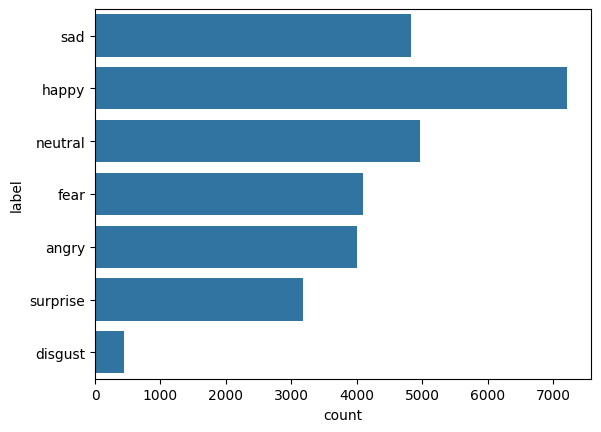

In [6]:
sns.countplot(train['label'])

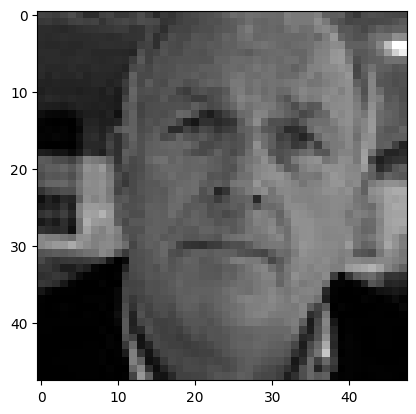

In [13]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

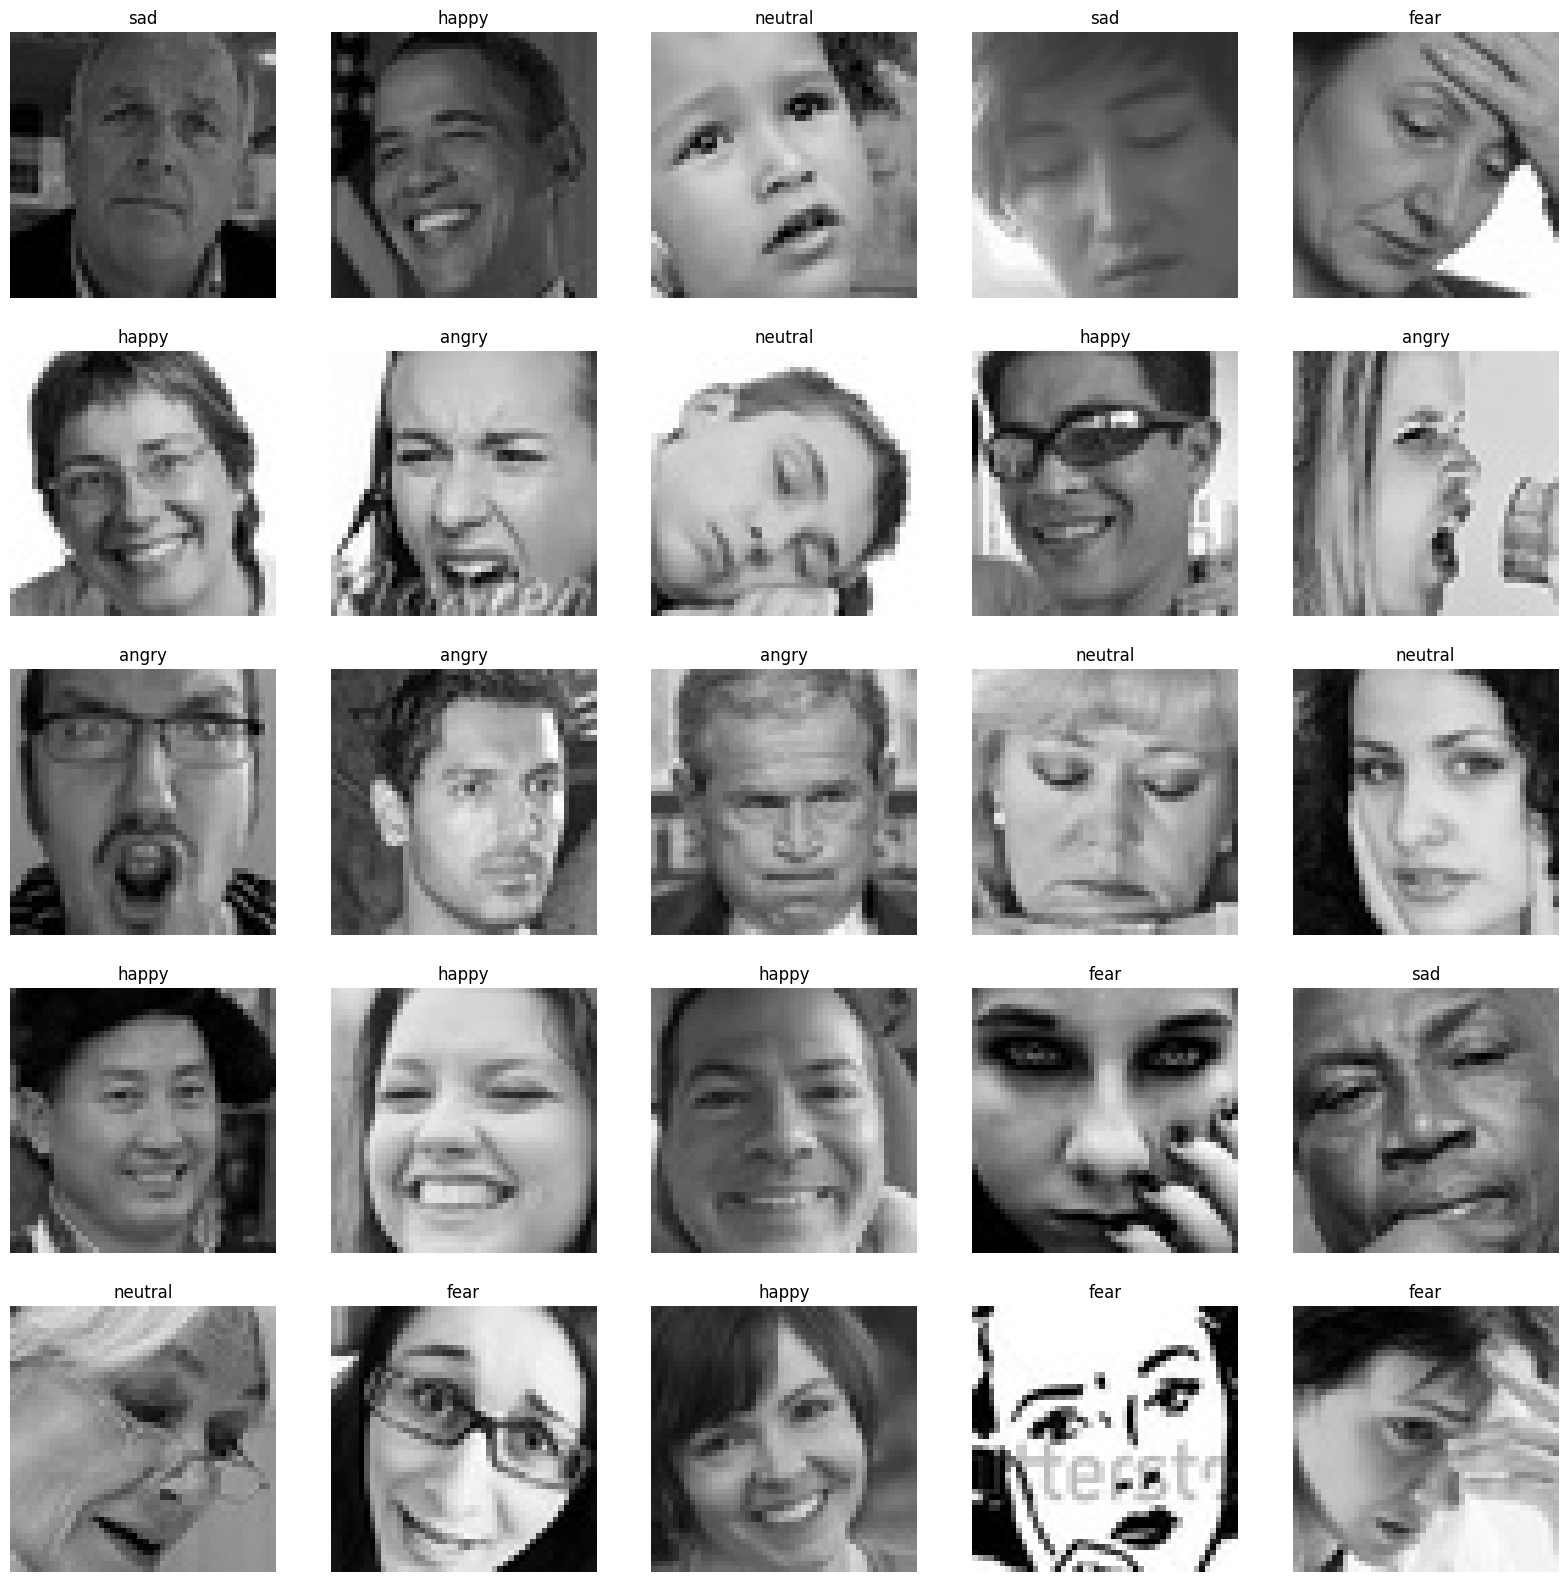

In [15]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [17]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [19]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [21]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [23]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [25]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [27]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7) 

In [29]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.])

In [31]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [33]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train the model
history = model.fit(x_train, y_train, epochs=25, validation_data=(x_test,y_test))

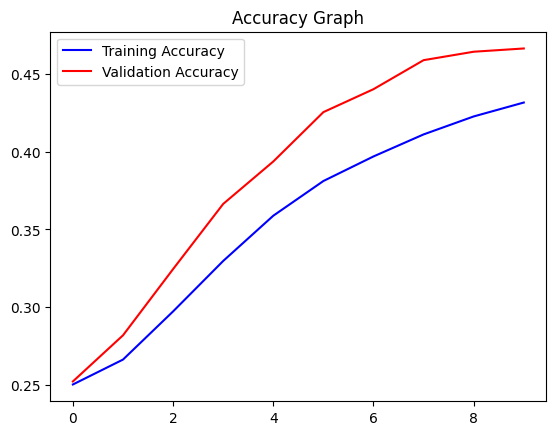

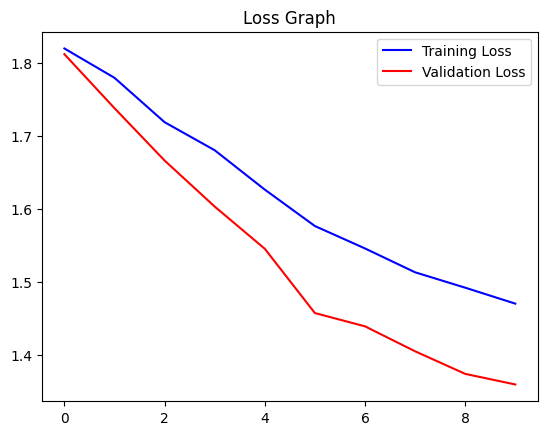

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()


Original Output: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted Output: happy


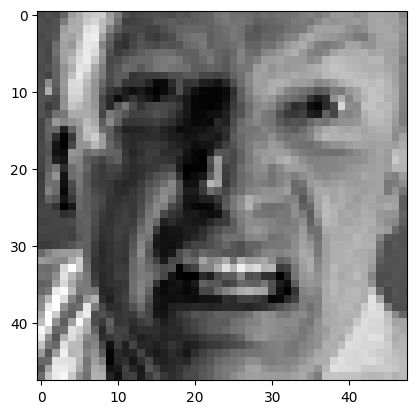

In [39]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')

In [58]:
# save the model
model.save(os.path.join('models','imageclassifier.h5'))

In [60]:
import cv2
from tensorflow.keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


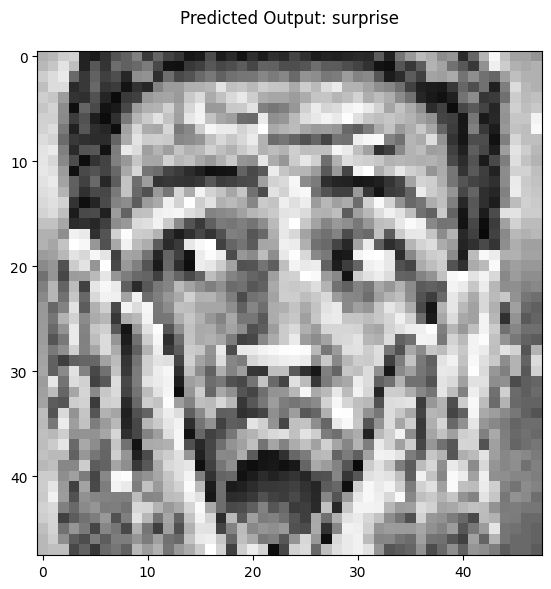

In [90]:

def preprocess_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Crop to focus on the face (adjust coordinates as needed)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        img = img[y:y+h, x:x+w]  # Crop to face region
    
    # Resize to 48x48 pixels
    img = cv2.resize(img, (48, 48))
    
    # Adaptive Histogram Equalization (CLAHE) for better contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    
    # Normalize pixel values to [0, 1]
    img = img / 255.0
    
    return img

# Load and preprocess your image
custom_image_path = './random/man4.jpg'  # Replace with your image path
processed_img = preprocess_image(custom_image_path)

# Make prediction
pred = model.predict(processed_img.reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]

# Display settings to match your reference
plt.figure(figsize=(6, 6))
plt.imshow(processed_img, cmap='gray', vmin=0, vmax=1)  # Force grayscale range
plt.title(f"Predicted Output: {prediction_label}", fontsize=12, pad=20)
plt.xticks(np.arange(0, 48, 10))  # X-axis ticks (0, 10, 20, 30, 40)
plt.yticks(np.arange(0, 48, 10))  # Y-axis ticks (0, 10, 20, 30, 40)
plt.grid(False)
plt.tight_layout()
plt.show()